In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_dir = 'H:\\FakeKasi'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [3]:
image_size = (128, 128)
batch_size = 4

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 133233 images belonging to 2 classes.
Found 38066 images belonging to 2 classes.
Found 19036 images belonging to 2 classes.


In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=image_size + (3,))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)  # For binary classification
model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

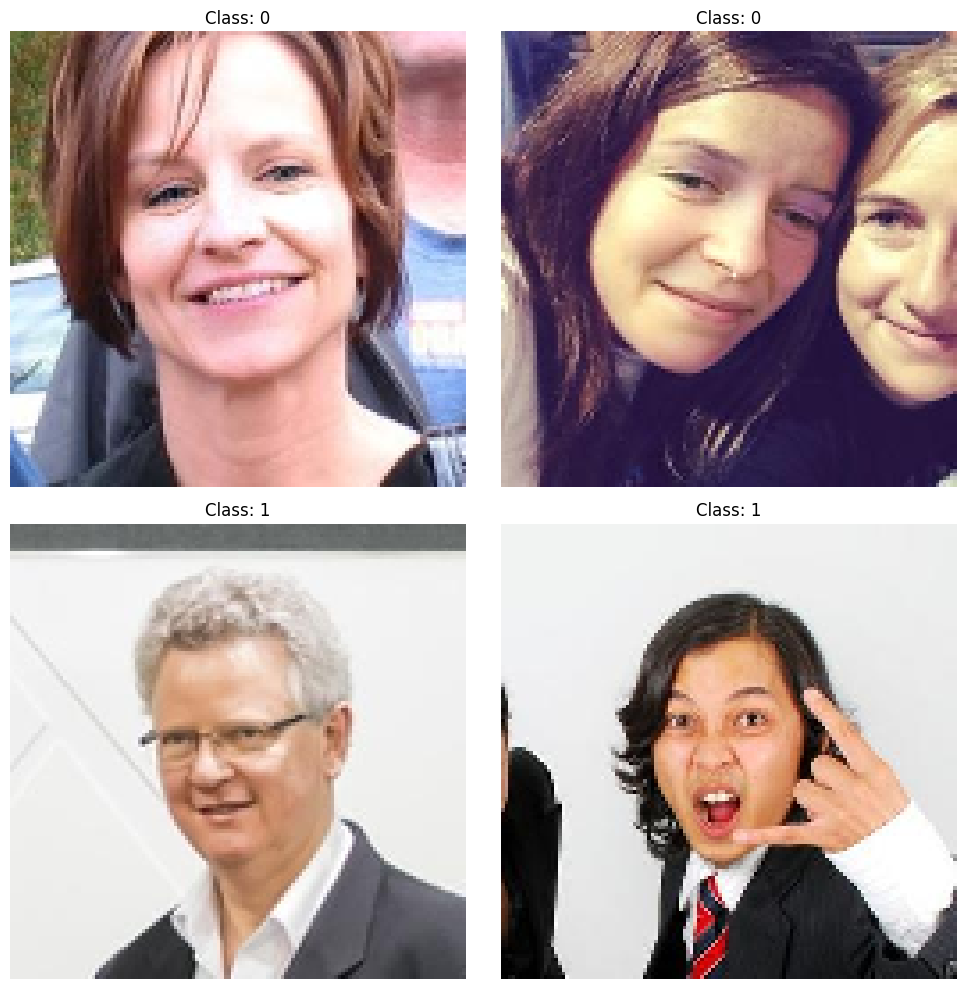

In [5]:
def plot_sample_images(generator):
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(min(4, len(x))):
        plt.subplot(2, 2, i+1)
        plt.imshow(x[i])
        plt.title("Class: " + str(int(y[i])))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)

Epoch 1/10
33309/33309 [==============================] - 1559s 46ms/step - loss: 0.7159 - accuracy: 0.5124 - val_loss: 3.9842 - val_accuracy: 0.5032
Epoch 2/10
33309/33309 [==============================] - 1542s 46ms/step - loss: 0.6937 - accuracy: 0.5204 - val_loss: 0.7662 - val_accuracy: 0.5841
Epoch 3/10
33309/33309 [==============================] - 1544s 46ms/step - loss: 0.5991 - accuracy: 0.6705 - val_loss: 2.6805 - val_accuracy: 0.6967
Epoch 4/10
33309/33309 [==============================] - 1527s 46ms/step - loss: 0.5033 - accuracy: 0.7488 - val_loss: 10.5504 - val_accuracy: 0.7291
Epoch 5/10
4759/4759 [==============================] - 71s 15ms/step - loss: 22.4101 - accuracy: 0.7231

InceptionV3 Test Accuracy: 0.7231035828590393
4759/4759 [==============================] - 63s 13ms/step
Confusion Matrix
[[7680 1835]
 [3436 6085]]
Classification Report
              precision    recall  f1-score   support

        Fake       0.69      0.81      0.74      9515
        Real 

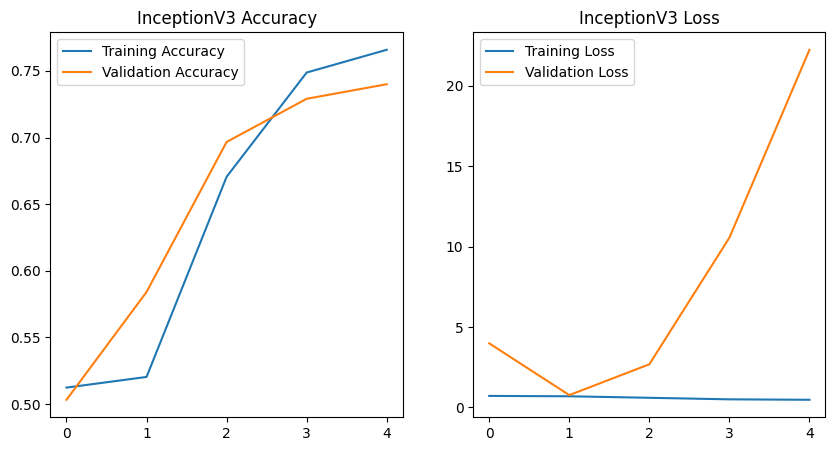

In [6]:
def train_and_evaluate(model, model_name):
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )

    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n{model_name} Test Accuracy: {test_acc}")

    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype("int32").flatten()

    print("Confusion Matrix")
    print(confusion_matrix(test_generator.classes, y_pred))

    print("Classification Report")
    print(classification_report(test_generator.classes, y_pred, target_names=['Fake', 'Real']))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()


train_and_evaluate(model, 'InceptionV3')
